# Diet and Cost Minimization Calculator
>    This calculator will minimize the cost given a set of food [variables] and constraints on those variables.  

## Goals
>Goal bodyweight = 180lbs</br>
>At least 1 gram protein per goal body weight per day</br> 
>Get at least 20 grams of fiber per day</br>
>Standard American Diet of 2000 calories per day</br>
>No more than 1/3 calories from carbohydrates</br>

## Setup

In [72]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import pulp
from IPython.display import display, HTML

## Table of Available Foods:

In [73]:
groceries = pd.read_csv('groceries.csv')
display(groceries,)

,Items,Carbohydrates,Protein,Fat,Calories,Fiber,Serving,Cost,Cat,Description
0,Apple,15,0,0.0,63,5,1 apple,0.220,Integer,Great Value Apple
1,Bread,14,3,1.0,70,2,1 slice,0.060,Integer,Great Value Wheat Bread
2,Broccoli,4,1,0.0,25,2,3oz=1cup,0.270,Integer,Great Value Frozen Broccoli
3,Brown_Rice,140,16,6.0,640,8,180g=1cup,0.270,Continuous,Great Value Brown Rice
4,Cheese,1,7,9.0,111,0,1oz,0.270,Integer,Great Value Mild Shredded Cheddar
5,Chicken,0,19,8.0,150,0,4oz,0.770,Integer,Costco Chicken Thighs
6,Coconut_Oil,0,0,14.0,120,0,1tbsp,0.100,Integer,Costco Coconut Oil
7,Coke,0,0,0.0,0,0,12oz,0.310,Integer,Coke Zero
8,Corn,11,2,1.0,60,3,4oz=1/2cup,0.360,Integer,Great Value Corn
9,Eggs,0,6,5.0,70,0,1 egg,0.140,Integer,Great Value 60 Count Crate


                    https://www.tablesgenerator.com/html_tables#
            https://pythonhosted.org/PuLP/CaseStudies/a_blending_problem.html

>   We are going to use the above table, nutrition values, cost and Python to minimize cost given our constraints

## Read the dataframe columns into python dictionaries

In [74]:
items=groceries['Items'].values
carbs=groceries.set_index('Items').drop(['Protein','Fat','Calories','Serving','Fiber','Cost','Cat','Description'],axis=1).to_dict()
protein=groceries.set_index('Items').drop(['Carbohydrates','Fat','Calories','Fiber','Serving','Cost','Cat','Description'],axis=1).to_dict()
fat=groceries.set_index('Items').drop(['Carbohydrates','Protein','Calories','Fiber','Serving','Cost','Cat','Description'],axis=1).to_dict()
cal=groceries.set_index('Items').drop(['Carbohydrates','Protein','Fat','Fiber','Serving','Cost','Cat','Description'],axis=1).to_dict()
fiber=groceries.set_index('Items').drop(['Carbohydrates','Protein','Fat','Serving','Calories','Cost','Cat','Description'],axis=1).to_dict()
serv=groceries.set_index('Items').drop(['Carbohydrates','Protein','Fat','Fiber','Calories','Cost','Cat','Description'],axis=1).to_dict()
cost=groceries.set_index('Items').drop(['Carbohydrates','Protein','Calories','Fiber','Serving','Fat','Cat','Description'],axis=1).to_dict()
category=groceries.set_index('Items').drop(['Carbohydrates','Protein','Calories','Fiber','Serving','Fat','Description','Cost'],axis=1).to_dict()
description=groceries.set_index('Items').drop(['Carbohydrates','Protein','Fiber','Calories','Serving','Fat','Cat','Cost'],axis=1).to_dict()

## Define the pulp problem set

In [75]:
# Create the 'diet' variable to contain the problem data
diet = pulp.LpProblem("Minimize Cost", pulp.LpMinimize)

# A dictionary called 'item_vars' is created to contain the referenced Variables
item_vars= pulp.LpVariable.dict('Items',items,lowBound=0,cat='Integer')
for i in category['Cat']:
    item_vars[i].cat=category['Cat'][i]

# The objective function is added to 'diet' first
diet += pulp.lpSum([cost['Cost'][i]*item_vars[i] for i in items]), "Cost"

## Secondary Constraints (Customization)

In [76]:
Calories=2000
Goal_Weight=180


# Inclusive constraints
diet += item_vars['Eggs'] <= 6
diet += item_vars['Turkey_Bacon'] >= 2

#diet += item_vars['Tuna'] >= 2
diet += item_vars['Tuna'] <= 2
diet += item_vars['Mayonnaise'] >= 1
diet += item_vars['Bread'] >= 4
diet += item_vars['Bread'] <= 4

#diet += item_vars['Ground_Beef'] >= 1  
diet += item_vars['Pasta_Sauce'] >= 1  
diet += item_vars['Elbow_Pasta'] >= 1 

# Exclusive constraints
diet += item_vars['Greek_Yogurt'] <= 0
diet += item_vars['Brown_Rice'] <= 0
diet += item_vars['Oats'] <= 0


## Primary Constraints

In [77]:
# The six constraints are added to 'diet'
diet += pulp.lpSum([protein['Protein'][i] * item_vars[i] for i in items]) <= Goal_Weight, "lowProteinRequirement"
diet += pulp.lpSum([protein['Protein'][i] * item_vars[i] for i in items]) >= Goal_Weight, "highProteinRequirement"
diet += 4*pulp.lpSum([carbs['Carbohydrates'][i] * item_vars[i] for i in items]) <= Calories/3, "CarbohydrateRequirement"
diet += 9*pulp.lpSum([fat['Fat'][i] * item_vars[i] for i in items]) <= Calories, "FatRequirement"
diet += pulp.lpSum([fiber['Fiber'][i] * item_vars[i] for i in items]) >= 20, "FiberRequirement"

# Total Calories
diet += pulp.lpSum([cal['Calories'][i] * item_vars[i] for i in items]) <= Calories, "lowCalorieRequirement"
diet += pulp.lpSum([cal['Calories'][i] * item_vars[i] for i in items]) >= Calories, "HighCalorieRequirement"

## Solve The System

In [78]:
diet.solve()
print(pulp.LpStatus[diet.status])

Optimal


# ------Results-------

## Cost

In [79]:
np.set_printoptions(precision=2)
print("\tDaily Meal Cost $" + str(round(pulp.value(diet.objective),2)))



	Daily Meal Cost $5.45


## Macro Breakdown

In [80]:
csum=psum=fsum=fisum=ccsum=cccsum=0
for var in diet.variables():
    csum += var.varValue * carbs['Carbohydrates'][str(var)[6:]]
    psum += var.varValue * protein['Protein'][str(var)[6:]]
    fsum += var.varValue * fat['Fat'][str(var)[6:]]
    fisum += var.varValue * fiber['Fiber'][str(var)[6:]]
    ccsum += var.varValue * cal['Calories'][str(var)[6:]]
    cccsum += var.varValue * cost['Cost'][str(var)[6:]]

print("\t" + str(round(csum)) + " grams of carbs for " + str(round(4*csum)) + " calories")
print("\t" + str(round(psum)) + " grams of protein for " + str(round(4*psum)) + " calories")
print("\t" + str(round(fsum)) + " grams of fat for " + str(round(9*fsum)) + " calories")
print("\t" + str(round(fisum)) + " grams of fiber")
print("\t" + str(round(ccsum)) + " total calories")

	155 grams of carbs for 618 calories
	180 grams of protein for 720 calories
	78 grams of fat for 702 calories
	21 grams of fiber
	2000 total calories


## Menu

In [81]:
namesData=[]
carbsData=[]
proteinData=[]
fatData=[]
fiberData=[]
calData=[]
costData=[]

for var in diet.variables():
    if var.varValue > 0:
        print("\t" + str(round(var.varValue,2)) + " x " + serv['Serving'][str(var)[6:]] + " of " + var.name[6:])
        namesData.append(str(var)[6:])
        carbsData.append(round(var.varValue*carbs['Carbohydrates'][str(var)[6:]],2))
        proteinData.append(round(var.varValue*protein['Protein'][str(var)[6:]],2))
        fatData.append(round(var.varValue*fat['Fat'][str(var)[6:]],2))
        fiberData.append(round(var.varValue*fiber['Fiber'][str(var)[6:]],2))
        calData.append(round(var.varValue*cal['Calories'][str(var)[6:]],2))
        costData.append(round(var.varValue*cost['Cost'][str(var)[6:]],2))

	4.0 x 1 slice of Bread
	4.0 x 1 egg of Eggs
	1.43 x 1/2cup dry of Elbow_Pasta
	1.09 x 1Tbsp=13g of Mayonnaise
	1.0 x 1/2cup=4oz of Pasta_Sauce
	2.0 x 2 Tbsp=32g of Peanut_Butter
	1.0 x 2oz=1/4cup of Tuna
	2.0 x 1 slice of Turkey_Bacon
	4.0 x 1 scoop of Whey


## Plot the Data

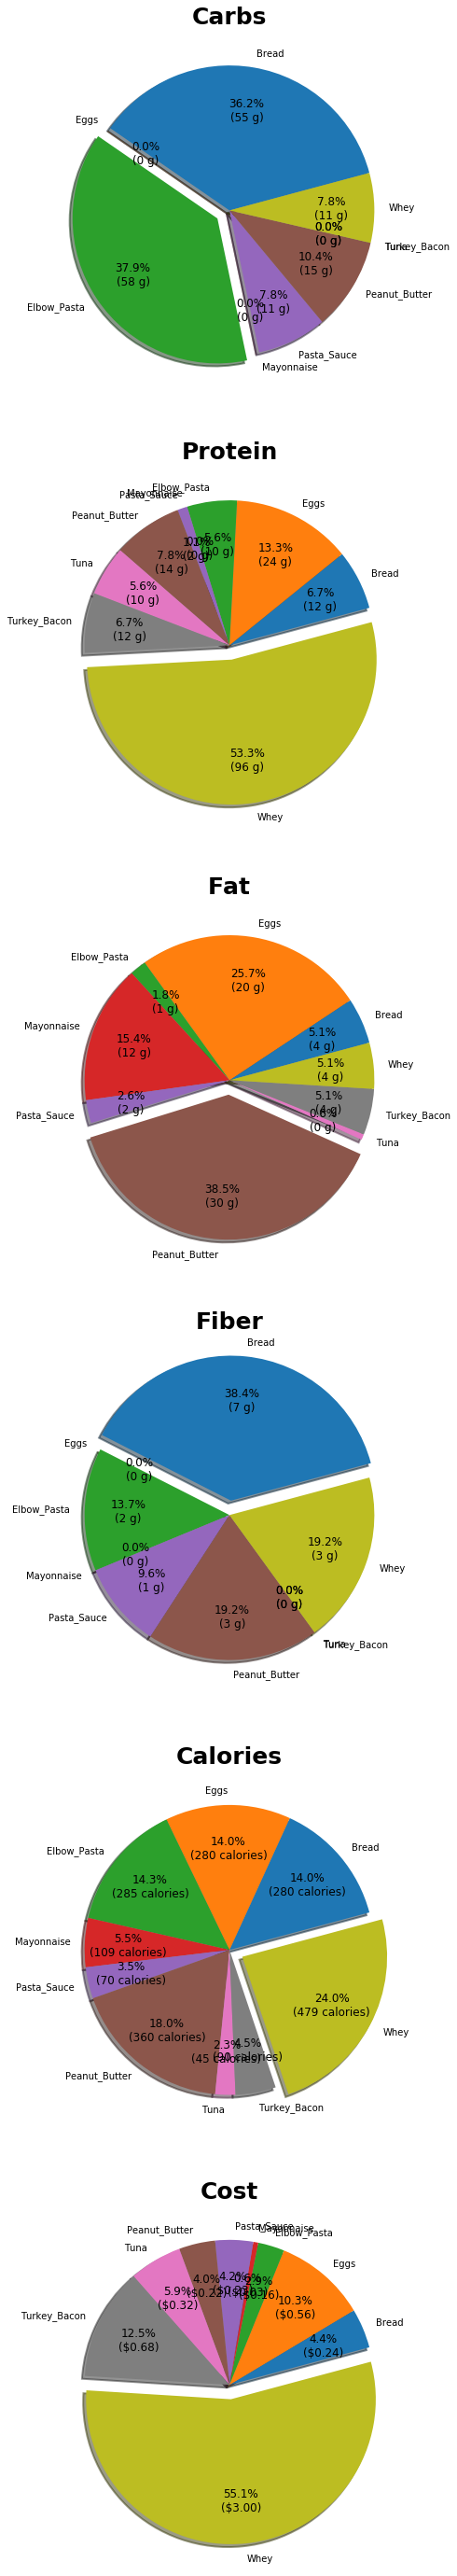

In [82]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

def func1(pct, allvals):
    absolute = pct/100.*np.sum(allvals)
    return "{:.1f}%\n(${:.2f})".format(pct, absolute)

def func2(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} calories)".format(pct, absolute)

def doColors(autotexts):
    for autotexts in autotexts:
        autotexts.set_color('black')
        #autotexts.size=15
        #autotexts.weight='bold'


explodeVal=0.1
autoWeightVal='normal'
labelVal='black'
autoTxtVal=12
titleVal=25
titleWeightVal='bold'
titleColor='black'
startAngleVal=15
        
print('\n\n')
pp.subplot(6,1,1)
pp.rcParams['text.color'] = labelVal
pp.title("Carbs",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(carbsData).index(np.max(carbsData))] = explodeVal
_,_,autotexts=pp.pie(carbsData,explode=explode,labels=namesData, autopct=lambda pct: func(pct, carbsData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)

pp.subplot(6,1,2) 
pp.rcParams['text.color'] = labelVal
pp.title("Protein",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(proteinData).index(np.max(proteinData))] = explodeVal
_,_,autotexts=pp.pie(proteinData,explode=explode,labels=namesData, autopct=lambda pct: func(pct, proteinData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)
 
pp.subplot(6,1,3) 
pp.rcParams['text.color'] = labelVal 
pp.title("Fat",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(fatData).index(np.max(fatData))] = explodeVal
_,_,autotexts=pp.pie(fatData,explode=explode,labels=namesData, autopct=lambda pct: func(pct, fatData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)

pp.subplot(6,1,4) 
pp.rcParams['text.color'] = labelVal 
pp.title("Fiber",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(fiberData).index(np.max(fiberData))] = explodeVal
_,_,autotexts=pp.pie(fiberData,explode=explode,labels=namesData, autopct=lambda pct: func(pct, fiberData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)

pp.subplot(6,1,5) 
pp.rcParams['text.color'] = labelVal
pp.title("Calories",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(calData).index(np.max(calData))] = explodeVal
_,_,autotexts=pp.pie(calData,explode=explode,labels=namesData, autopct=lambda pct: func2(pct, calData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)

pp.subplot(6,1,6)
pp.rcParams['text.color'] = labelVal
pp.title("Cost",fontsize=titleVal,weight=titleWeightVal,color=titleColor);
explode = np.zeros(len(namesData))
explode[list(costData).index(np.max(costData))] = explodeVal
_,_,autotexts=pp.pie(costData,explode=explode,labels=namesData, autopct=lambda pct: func1(pct, costData),shadow=True, \
    startangle=startAngleVal,pctdistance=.7,wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})
doColors(autotexts)
pp.setp(autotexts,size=autoTxtVal,weight=autoWeightVal)

fig=pp.gcf()
fig.set_size_inches(50,50)

pp.show()